# Amazon food review dataset apply clustering polarity review

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Use xi and apply kmeans(using kmenas++) for various value of k using BOW,TFIDF etc. find best k

For each centroid read few items that could be similar review like food, mobile

Implement hierarchical try with different cluster for different text presentation(BOW,TFIDF)

Try dbscan with W2V use dim of vec 100, minpts=2*d, use all data

Use elbow methood or similar to find best eps

Try other eps and see how sensitive it is

# Import data and libraries
 
 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('database.sqlite') 
#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
#filtered_data.sample(5)
filtered_data['Score'].value_counts()
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [3]:
#take only 2500 + 2500 data
from sklearn.cross_validation import train_test_split,KFold
_ , clean_data = train_test_split(sorted_data, test_size = 5000, stratify = sorted_data['Score'] ,random_state=0)
clean_data['Score'].value_counts()

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


positive    4216
negative     784
Name: Score, dtype: int64

In [4]:
# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

In [5]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1    

In [6]:
clean_data['CleanedText']=final_string
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
clean_data.reset_index(inplace=True)
clean_data.sample(2)

C:\Users\suman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
4547,7253,7924,B00166D8TW,A3MILDAIBVX6WM,JShoe,0,0,positive,1218153600,Eggcellent Product!,"This egg protein is great!<br />First off, it ...",b'egg protein great first sweeten stevia natur...
2530,375849,406408,B0006G4YK0,A2DUSUQPBGL9F8,Happy Shopper,0,0,negative,1311292800,nope,I really really wanted these to work for my ad...,b'realli realli want work adopt pom ador senio...


# Use kmeans
# BOW

(5000, 9715)
<class 'scipy.sparse.csr.csr_matrix'>


C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


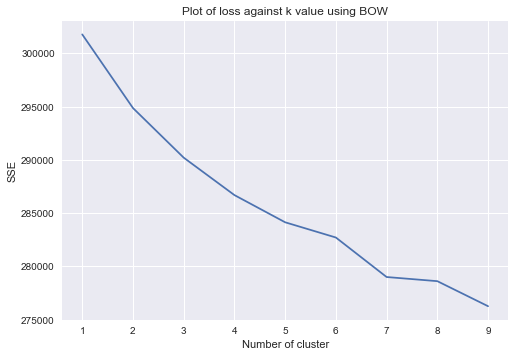

[1 1 1 ..., 1 1 1]
b'dog love healthi treat great train crumbl tri break piec'
b'tobin jame excel wine one especi husband enjoy tobin jame merlot difficult find good wine reason price ever chanc tobin jame tast room paso robl high recommend cheer'
b'ive eat strict paleo eat diet near one year includ ghee huge tast benefit ghee virtual lactos healthier regular butter brush chicken breast bake bit crush black pepper sunflow seed flavor realli come ingredi brand anoth one two favorit usual list prime avail'
b'use year give long last energi boost sudden let good tast put travel'
b'chill oragemint classic refresh dri scratchi pallet premium price met except tast exceed satisfact'
b'whether use gourmet sauc pack natur flavor alway make assum msg meal darn good fill tast feel hungri done eat slowli chew well get full benefit fiber think tast realli good realli fresh keep coupl case hand part emerg food stash take work quick easi lunch pleas find amazon seen one store grant dont shop store muc

In [7]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(clean_data['CleanedText'].values)
print(final_counts.get_shape())
print(type(final_counts))
#print(final_counts[[1]])
#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV

x=final_counts
x_bow=x
kmeans=KMeans(n_clusters=2, random_state=0).fit(x)
kmeans.cluster_centers_


sse = {}
for k in range(1, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=100).fit(x)
    #x["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value using BOW")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


# Use k=2 and build cluster
kmeans = KMeans(init='k-means++',n_clusters=2, max_iter=100).fit(x)
print(kmeans.labels_)    
# find some data from clusters

#cluster_map = pd.DataFrame()
#cluster_map['data_index'] = x.index
#cluster_map['cluster'] = kmeans.labels_
#cluster_map[cluster_map.cluster == 1]

#print("Top terms per cluster:")
#order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
#terms = count_vect.get_feature_names()
#for i in range(2):
#    print ("Cluster ",i)
#    for ind in order_centroids[i, :10]:
#        print (' %s' % terms[ind])
    
    
#Find few sentences from different cluster
# Find sentences with 0 and 1 cluster
#print(kmeans.labels_)
#find cluster 1 index
a=np.where(kmeans.labels_ == 1)[0]
b=np.where(kmeans.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a[0]])
print(clean_data['CleanedText'][a[1]])
print(clean_data['CleanedText'][a[2]])
print(clean_data['CleanedText'][a[3]])
print(clean_data['CleanedText'][a[4]])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b[0]])
print(clean_data['CleanedText'][b[1]])
print(clean_data['CleanedText'][b[2]])
print(clean_data['CleanedText'][b[3]])
print(clean_data['CleanedText'][b[4]])



# Cluster summersing
As we have formed 2 cluster and 5 sample from each cluster. Though its not clear but it seems
1) cluster 1 talks about detail review of food type and short review
2) cluster 2 talks about short review of drink type and long review


In [8]:
#print(dir()) 
#print(globals())
#print(locals())

# TFIDF

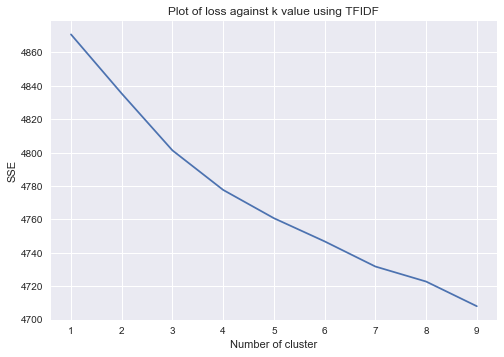

[1 1 1 ..., 1 1 1]
0    b'dog love healthi treat great train crumbl tr...
1    b'tobin jame excel wine one especi husband enj...
2    b'ive eat strict paleo eat diet near one year ...
3    b'use year give long last energi boost sudden ...
4    b'chill oragemint classic refresh dri scratchi...
Name: CleanedText, dtype: object
5     b'great rich coffe prefer pilon decaf interest...
8     b'love coffe coffe connoisseur enjoy good cup ...
39    b'coffe tast like fresh coffe tast brew stale ...
41    b'tri price thought differ style cup less expe...
45    b'thrill find tulli french roast decaf back st...
Name: CleanedText, dtype: object


In [9]:
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
x=final_counts
x_tfidf=x
kmeans=KMeans(n_clusters=2, random_state=0).fit(x)
kmeans.cluster_centers_
sse = {}
for k in range(1, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=100).fit(x)
    #x["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value using TFIDF")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# Use k=2 and build cluster
kmeans = KMeans(init='k-means++',n_clusters=2, max_iter=100).fit(x)
print(kmeans.labels_)    
# find some data from clusters

#cluster_map = pd.DataFrame()
#cluster_map['data_index'] = x.index
#cluster_map['cluster'] = kmeans.labels_
#cluster_map[cluster_map.cluster == 1]

#print("Top terms per cluster:")
#order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
#terms = count_vect.get_feature_names()
#for i in range(2):
#    print ("Cluster ",i)
#    for ind in order_centroids[i, :10]:
#        print (' %s' % terms[ind])
    
    
#Find few sentences from different cluster
# Find sentences with 0 and 1 cluster
#print(kmeans.labels_)
#find cluster 1 index
a=np.where(kmeans.labels_ == 1)[0]
b=np.where(kmeans.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a][0:5])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b][0:5])



# AVG W2V

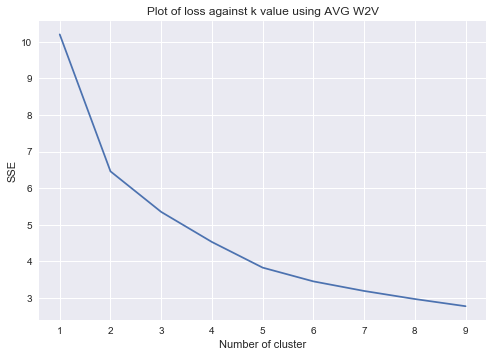

[0 0 1 ..., 0 1 0]
2    b'ive eat strict paleo eat diet near one year ...
4    b'chill oragemint classic refresh dri scratchi...
5    b'great rich coffe prefer pilon decaf interest...
6    b'greasi plain simpl reliev itchi scalp negat ...
8    b'love coffe coffe connoisseur enjoy good cup ...
Name: CleanedText, dtype: object
0    b'dog love healthi treat great train crumbl tr...
1    b'tobin jame excel wine one especi husband enj...
3    b'use year give long last energi boost sudden ...
7    b'whether use gourmet sauc pack natur flavor a...
9    b'bought licoric pipe dad love black old fashi...
Name: CleanedText, dtype: object


In [10]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)   
# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  
x = sent_vectors
x_avgw2v=x
from sklearn.preprocessing import normalize
x = normalize(x, norm='l2', axis=0)

kmeans=KMeans(n_clusters=2, random_state=0).fit(x)
kmeans.cluster_centers_
sse = {}
for k in range(1, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=100).fit(x)
    #x["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value using AVG W2V")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# Use k=2 and build cluster
kmeans = KMeans(init='k-means++',n_clusters=2, max_iter=100).fit(x)
print(kmeans.labels_)    
# find some data from clusters

#cluster_map = pd.DataFrame()
#cluster_map['data_index'] = x.index
#cluster_map['cluster'] = kmeans.labels_
#cluster_map[cluster_map.cluster == 1]

#print("Top terms per cluster:")
#order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
#terms = count_vect.get_feature_names()
#for i in range(2):
#    print ("Cluster ",i)
#    for ind in order_centroids[i, :10]:
#        print (' %s' % terms[ind])
    
    
#Find few sentences from different cluster
# Find sentences with 0 and 1 cluster
#print(kmeans.labels_)
#find cluster 1 index
a=np.where(kmeans.labels_ == 1)[0]
b=np.where(kmeans.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a][0:5])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b][0:5])





# AVG TFIDF W2V


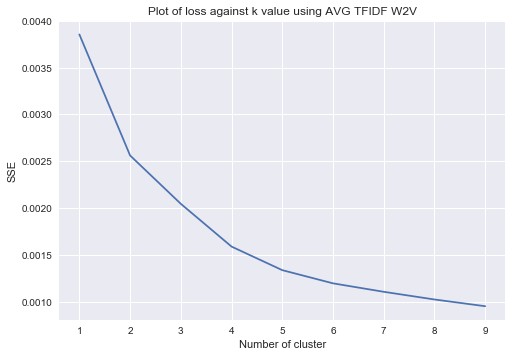

[0 0 0 ..., 0 1 1]
4     b'chill oragemint classic refresh dri scratchi...
5     b'great rich coffe prefer pilon decaf interest...
8     b'love coffe coffe connoisseur enjoy good cup ...
11    b'ive never much soda drinker alway lookout al...
12    b'delight receiv new drink ive fan long time h...
Name: CleanedText, dtype: object
0    b'dog love healthi treat great train crumbl tr...
1    b'tobin jame excel wine one especi husband enj...
2    b'ive eat strict paleo eat diet near one year ...
3    b'use year give long last energi boost sudden ...
6    b'greasi plain simpl reliev itchi scalp negat ...
Name: CleanedText, dtype: object


In [11]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
#import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
#import gensim

i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)   

tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(clean_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
#tfidf_sent_vectors.


x=tfidf_sent_vectors
x_avgw2vtfidf=x
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)

kmeans=KMeans(n_clusters=2, random_state=0).fit(x)
kmeans.cluster_centers_
sse = {}
for k in range(1, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=100).fit(x)
    #x["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value using AVG TFIDF W2V")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


# Use k=2 and build cluster
kmeans = KMeans(init='k-means++',n_clusters=2, max_iter=100).fit(x)
print(kmeans.labels_)    
# find some data from clusters

#cluster_map = pd.DataFrame()
#cluster_map['data_index'] = x.index
#cluster_map['cluster'] = kmeans.labels_
#cluster_map[cluster_map.cluster == 1]

#print("Top terms per cluster:")
#order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
#terms = count_vect.get_feature_names()
#for i in range(2):
#    print ("Cluster ",i)
#    for ind in order_centroids[i, :10]:
#        print (' %s' % terms[ind])
    
    
#Find few sentences from different cluster
# Find sentences with 0 and 1 cluster
#print(kmeans.labels_)
#find cluster 1 index
a=np.where(kmeans.labels_ == 1)[0]
b=np.where(kmeans.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a][0:5])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b][0:5])




# Try hierarchical cluster
# BOW

In [12]:
# copud from https://raw.githubusercontent.com/jqmviegas/jqm_cvi/master/jqmcvi/base.py
#ignore warning
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
x=x_bow
#for index, metric in enumerate([1,2,3]):
#    model = AgglomerativeClustering(n_clusters=metric,linkage="average")
#    model.fit(x)
#    plt.figure()
#    plt.axes([0, 0, 1, 1])
#    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#        plt.plot(x[model.labels_ == l].T, c=c, alpha=.5)
#    plt.axis('tight')
##    plt.axis('off')
#    plt.suptitle("AgglomerativeClustering(cluster=%s)" % metric, size=20)
#plt.show()

cluster=AgglomerativeClustering(n_clusters=2).fit(x.toarray())
a=np.where(cluster.labels_ == 1)[0]
b=np.where(cluster.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a[0]])
print(clean_data['CleanedText'][a[1]])
print(clean_data['CleanedText'][a[2]])
print(clean_data['CleanedText'][a[3]])
print(clean_data['CleanedText'][a[4]])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b[0]])
print(clean_data['CleanedText'][b[1]])
print(clean_data['CleanedText'][b[2]])
print(clean_data['CleanedText'][b[3]])
print(clean_data['CleanedText'][b[4]])



b'dog love healthi treat great train crumbl tri break piec'
b'tobin jame excel wine one especi husband enjoy tobin jame merlot difficult find good wine reason price ever chanc tobin jame tast room paso robl high recommend cheer'
b'ive eat strict paleo eat diet near one year includ ghee huge tast benefit ghee virtual lactos healthier regular butter brush chicken breast bake bit crush black pepper sunflow seed flavor realli come ingredi brand anoth one two favorit usual list prime avail'
b'use year give long last energi boost sudden let good tast put travel'
b'chill oragemint classic refresh dri scratchi pallet premium price met except tast exceed satisfact'
b'coffe tast like fresh coffe tast brew stale coffe bean disappoint expect good cup coffe come brooklyn regular drink starbuck coffe pleas varieti tri rang verona blond veranda brand tast like fresh brew look cup coffe order compani'
b'freez dri ice cream great tast exact like expens kind astronaut packag fraction price receiv unders

# SUmmarizing each cluster
first cluster talks about food type review and second one coffee type review(long review)

# TFIDF

In [13]:
from sklearn.cluster import AgglomerativeClustering
x=x_tfidf
#for index, metric in enumerate([1,2,3]):
#    model = AgglomerativeClustering(n_clusters=metric,linkage="average")
#    model.fit(x)
#    plt.figure()
#    plt.axes([0, 0, 1, 1])
#    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#        plt.plot(x[model.labels_ == l].T, c=c, alpha=.5)
#    plt.axis('tight')
##    plt.axis('off')
#    plt.suptitle("AgglomerativeClustering(cluster=%s)" % metric, size=20)
#plt.show()

cluster=AgglomerativeClustering(n_clusters=2).fit(x.toarray())
a=np.where(cluster.labels_ == 1)[0]
b=np.where(cluster.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a][0:6])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b][0:6])

59     b'headlin pretti much sum bigalow green tea ba...
68     b'far yummi tea purchas great cold damp night ...
75     b'rule big fan herbal tea ill give anyth tri l...
109    b'anoth delici tea lipton blackberri tast defi...
113    b'coupl year enjoy tea last snack day light su...
142    b'realli enjoy tea drink howev need coffe ive ...
Name: CleanedText, dtype: object
0    b'dog love healthi treat great train crumbl tr...
1    b'tobin jame excel wine one especi husband enj...
2    b'ive eat strict paleo eat diet near one year ...
3    b'use year give long last energi boost sudden ...
4    b'chill oragemint classic refresh dri scratchi...
5    b'great rich coffe prefer pilon decaf interest...
Name: CleanedText, dtype: object


#plot accuracy with k value

# W2V ADG

In [14]:
#for index, metric in enumerate([1,2,3]):
#    model = AgglomerativeClustering(n_clusters=metric,linkage="average")
#    model.fit(x)
#    plt.figure()
#    plt.axes([0, 0, 1, 1])
#    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#        plt.plot(x[model.labels_ == l].T, c=c, alpha=.5)
#    plt.axis('tight')
##    plt.axis('off')
#    plt.suptitle("AgglomerativeClustering(cluster=%s)" % metric, size=20)
#plt.show()
x=x_avgw2v
cluster=AgglomerativeClustering(n_clusters=2).fit(x)
a=np.where(cluster.labels_ == 1)[0]
b=np.where(cluster.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a][0:6])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b][0:6])

0     b'dog love healthi treat great train crumbl tr...
7     b'whether use gourmet sauc pack natur flavor a...
9     b'bought licoric pipe dad love black old fashi...
13    b'famili love eat crisp bread tast great plain...
14    b'haribo candi usual good excit receiv centipe...
15    b'say addict buy cannot maintain disciplin nee...
Name: CleanedText, dtype: object
1    b'tobin jame excel wine one especi husband enj...
2    b'ive eat strict paleo eat diet near one year ...
3    b'use year give long last energi boost sudden ...
4    b'chill oragemint classic refresh dri scratchi...
5    b'great rich coffe prefer pilon decaf interest...
6    b'greasi plain simpl reliev itchi scalp negat ...
Name: CleanedText, dtype: object



# W2V AVG TFIDF

In [15]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import normalize
import time

x=x_avgw2vtfidf
#cluster=AgglomerativeClustering(n_clusters=2).fit(x)


#for index, metric in enumerate([1,2,3]):
#    model = AgglomerativeClustering(n_clusters=metric,linkage="average")
#    model.fit(x)
#    plt.figure()
#    plt.axes([0, 0, 1, 1])
#    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
#        plt.plot(x[model.labels_ == l].T, c=c, alpha=.5)
#    plt.axis('tight')
##    plt.axis('off')
#    plt.suptitle("AgglomerativeClustering(cluster=%s)" % metric, size=20)
#plt.show()

cluster=AgglomerativeClustering(n_clusters=2).fit(x)
a=np.where(cluster.labels_ == 1)[0]
b=np.where(cluster.labels_ == 0)[0]
#check 5 text for cluster 1
print(clean_data['CleanedText'][a][0:6])
#check 5 text for cluster 1
print(clean_data['CleanedText'][b][0:6])

0     b'dog love healthi treat great train crumbl tr...
7     b'whether use gourmet sauc pack natur flavor a...
14    b'haribo candi usual good excit receiv centipe...
15    b'say addict buy cannot maintain disciplin nee...
17    b'pleas dont fool buy item cannot return box b...
18    b'hard find local groceri amazon deal can come...
Name: CleanedText, dtype: object
1    b'tobin jame excel wine one especi husband enj...
2    b'ive eat strict paleo eat diet near one year ...
3    b'use year give long last energi boost sudden ...
4    b'chill oragemint classic refresh dri scratchi...
5    b'great rich coffe prefer pilon decaf interest...
6    b'greasi plain simpl reliev itchi scalp negat ...
Name: CleanedText, dtype: object


# DBSCAN
#try dbscan use W2V use dim of vec 100, minpts=2*d use all data use elbow methood to find eps 
#try other eps and see how sensitive it is
# W2V

In [16]:
_ , clean_data = train_test_split(sorted_data, test_size = 10000, stratify = sorted_data['Score'] ,random_state=0)
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1    


clean_data['CleanedText']=final_string
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
clean_data.reset_index(inplace=True)
clean_data.sample(2)

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim
i=0
#create a list of list to be used in W2V 
list_of_sent=[]
for sent in clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
# excluding words occuring less than 50 because the cluster is not clear to distinguish
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=50,size=100, workers=4)   
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)  
x = sent_vectors
x_avgw2v=x

# Use AVG W2V

num_cluster including noise 1 {0}
['positive' 'positive' 'positive' ..., 'positive' 'positive' 'positive']


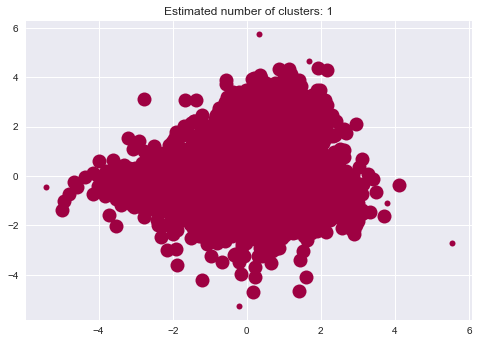

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
x=x_avgw2v
x = StandardScaler().fit_transform(x)
#print(x)

#for i in range(6,30):
#for i in range(50,55):
#   j=i/3
#   db = DBSCAN(eps=j, min_samples=500).fit(x)
#   labels = db.labels_
#   print(j,set(labels))

db = DBSCAN(eps=16.6, min_samples=200).fit(x)
labels=db.labels_   
num_clusters = len(set(labels))
print("num_cluster including noise",num_clusters,set(labels))
y = clean_data['Score']
labels_true=y.values
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#print("no of cluster ignoring noise",n_clusters_)
#print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"     % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"      % metrics.silhouette_score(x, labels))

print(labels_true)

import matplotlib.pyplot as plt
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [19]:
#import matplotlib.pyplot as pl

#for i in range(1,20):
#  j=i/10
#  dbscan = DBSCAN(eps=j, min_samples=100).fit(x)
#  labels = db.labels_
#  print(j,set(labels))

#from sklearn.decomposition import PCA
#pca = PCA(n_components=2).fit(x)
#pca_2d = pca.transform(x)
#for i in range(0, pca_2d.shape[0]):
#  if (dbscan.labels_[i] == 0):
#    c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
#  elif (dbscan.labels_[i] == 1):
#    c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
#  elif (dbscan.labels_[i] == -1):
#    c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
#  pl.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2','Noise'])
#  pl.title('DBSCAN finds 2 clusters and noise')
#  pl.show()
#print(db.labels_)

[0 0 0 ..., 0 0 0]


# SUmmarizing each cluster
As we are not getting 2 cluster with DBSCAN there is no point in summerizing data


# Conclusion
W2V takes time to implement.
For kmeans better model is like below W2VAVGTFIDF>W2VAVG>TFIDF>BOW
The different clustering texts are quite similar
In DBSCAN its difficult to choose eps to get 2 cluster, most of the cases getting 0 cluster, I am getting only one cluster and outliers in best case.

# Steps followed
Only !=3 reviews are taken Mark >3 as positive and <3 as negative. Sort data as per product id in ascending order Deduplication of entries for same profilename,userid, time, text and take first element Get stratified sampling of 5k data Clean html and punctuation Convert to uppercase and word<3 are rejected data sorted on time Split the data in train and test to 70:30
BOW TFIDF AVGW2V and AVG TFIDF W2V was used in whole data
For kmeans clustering different value of k clustering error was plotted.
AgglomerativeClustering for 2 cluster is formed
DBSCAN eps=16.6, min_samples=200
For top 5 review of each cluster tried to summarize clustering type